<a href="https://colab.research.google.com/github/mrigankpawagi/EfficientAttention-TermPaper/blob/main/Efficient_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contributors: Rohit Jorige, Mrigank Pawagi, Nagasai, Sahil Chaudhary

Advisor: Dhruva Kashyap

**Efficient Attention**

The dominant sequence transduction models are based on complex recurrent or convulational neural networks that include an encoder and decoder. Vashwani et. al. proposed new simple network architecture, the Transformer based solely on attention mechanism dispensing with recurrence and convulations entirely. There is a scope of improvement on the mechanism proposed by vaswant et. al.

Attention is a very important mechanism introduce in the field of LLMs and understanding the improvement in attention is very important. The time complexity of simple attention mechanism is quadratic in nature and its a problematic time complexity for a very large number of data. Thus, Approv vyas et. al. proposed a linear transformer for the same introducing kernels to similarity function.

This Google Collab includes the experiments done around
1. Attention
2. Linear Transformer
3. Improving attention using LoRA
4. (And others???)

We have tried various experiments around MNIST, cifar-10 and compare the time required to perform forward and backward pass for variety of sequence lengths and batch sizes.

**Credits**
1. https://github.com/idiap/fast-transformers?tab=readme-ov-file
2. https://github.com/lucidrains/linear-attention-transformer
3. https://github.com/EugenHotaj/pytorch-generative/blob/master/pytorch_generative/nn/attention.py
4. https://github.com/davidsvy/cosformer-pytorch
5. https://github.com/kyle-gao/TF_Transformer

**Papers Followed:**
1. Attention is all you need: https://arxiv.org/pdf/1706.03762.pdf
2. Transformers are RNNs: https: //arxiv.org/pdf/2006.16236.pdf
3. LoRA: https://arxiv.org/pdf/2106.09685.pdf

# Installation and First Steps
The installation is directly from PyPI. This will take several minutes since it compiles several custom CUDA kernels, not only for linear autoregressive attention. Maybe grab a coffee (if you are into these things).

Bare with me. It takes 20 minutes to just install it.

In [1]:
!pip install pytorch-fast-transformers

Defaulting to user installation because normal site-packages is not writeable


Try validating freshly installed package by creating a small transformer encoder and running it on dummy data.

In [3]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
#Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 64
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)



In [5]:
from fast_transformers.builders import TransformerEncoderBuilder
from fast_transformers.masking import LengthMask, TriangularCausalMask
import torch

model = TransformerEncoderBuilder.from_kwargs(
    n_layers=4,
    n_heads=4,
    feed_forward_dimensions=128,
    query_dimensions=32,
    value_dimensions=32,
    attention_type="full" # this means normal softmax attention
).get()

x = torch.rand(
    10,  # batch size
    100, # sequence length
    128  # feature dimensions
)
y = model(x) # calling without masks which means attend to everything
y = model(
    x,
    attn_mask=TriangularCausalMask(100),   # causal masking
    length_mask=LengthMask(torch.tensor([
        100, 70, 60, 30, 80, 100,          # The sequence length for every
        50, 40, 10, 20                     # sample in the batch
    ]))
)
print("If you reached here, everything works", y.shape)

If you reached here, everything works torch.Size([10, 100, 128])


#Autoregressive Generation for MNIST

We define two modules for autoregressive image generation for general purposes. One uses a recurrent formulation(since we are trying to prove Linear Transformers are RNNS) AND the other similar to the default PyTourch implementation that just accepts the whole sequence.

Both of the implementation involves wrapping a transformer with an input embedding layer and a prediction layer.

In [6]:
import math
from fast_transformers.builders import RecurrentEncoderBuilder

class RecurrentGenerator(torch.nn.Module):
    class PositionalEncoding(torch.nn.Module):
        def __init__(self, d_model, dropout=0.0, max_len=5000):
            super(RecurrentGenerator.PositionalEncoding, self).__init__()
            self.dropout = torch.nn.Dropout(p=dropout)
            self.d_model = d_model
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)

        def forward(self, x, i):
            pos_embedding =  self.pe[0, i:i+1]
            x = torch.cat(
                [x, pos_embedding.expand_as(x)],
                dim=1
            )
            return self.dropout(x)

    def __init__(self, d_model, sequence_length, mixtures,
                 attention_type="full", n_layers=4, n_heads=4,
                 d_query=32, dropout=0.1, softmax_temp=None,
                 attention_dropout=0.1):
        super(RecurrentGenerator, self).__init__()

        self.pos_embedding = self.PositionalEncoding(
            d_model//2,
            max_len=sequence_length
        )
        self.value_embedding = torch.nn.Embedding(
            256,
            d_model//2
        )
        self.transformer = RecurrentEncoderBuilder.from_kwargs(
            attention_type=attention_type,
            n_layers=n_layers,
            n_heads=n_heads,
            feed_forward_dimensions=n_heads*d_query*4,
            query_dimensions=d_query,
            value_dimensions=d_query,
            dropout=dropout,
            softmax_temp=softmax_temp,
            attention_dropout=attention_dropout
        ).get()
        self.predictor = torch.nn.Linear(
            d_model,
            mixtures * 3
        )

    def forward(self, x, i=0, memory=None):
        x = x.view(x.shape[0])
        x = self.value_embedding(x)
        x = self.pos_embedding(x, i)
        y_hat, memory = self.transformer(x, memory)
        y_hat = self.predictor(y_hat)

        return y_hat, memory


In [7]:
class Generator(torch.nn.Module):
    class PositionalEncoding(torch.nn.Module):
        def __init__(self, d_model, dropout=0.0, max_len=5000):
            super(Generator.PositionalEncoding, self).__init__()
            self.dropout = torch.nn.Dropout(p=dropout)
            self.d_model = d_model
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)

        def forward(self, x):
            pos_embedding =  self.pe[:, :x.size(1), :]
            pos_embedding = torch.repeat_interleave(pos_embedding, x.shape[0], dim=0)
            x =  torch.cat([x, pos_embedding], dim=2)
            return self.dropout(x)

    def __init__(self, d_model, sequence_length, mixtures,
                 attention_type="full", n_layers=4, n_heads=4,
                 d_query=32, dropout=0.1, softmax_temp=None,
                 attention_dropout=0.1):
        super(Generator, self).__init__()

        self.pos_embedding = self.PositionalEncoding(
            d_model//2,
            max_len=sequence_length
        )
        self.value_embedding = torch.nn.Embedding(
            256,
            d_model//2
        )

        self.transformer = TransformerEncoderBuilder.from_kwargs(
            attention_type=attention_type,
            n_layers=n_layers,
            n_heads=n_heads,
            feed_forward_dimensions=n_heads*d_query*4,
            query_dimensions=d_query,
            value_dimensions=d_query,
            dropout=dropout,
            softmax_temp=softmax_temp,
            attention_dropout=attention_dropout
        ).get()

        hidden_size = n_heads*d_query
        self.predictor = torch.nn.Linear(
            hidden_size,
            mixtures * 3
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.value_embedding(x)
        x = self.pos_embedding(x)
        triangular_mask = TriangularCausalMask(x.shape[1], device=x.device)
        y_hat = self.transformer(x, attn_mask=triangular_mask)
        y_hat = self.predictor(y_hat)

        return y_hat

In [8]:
def sample_mol(y_hat, num_classes=256):
    """Sample from mixture of logistics.

    y_hat: NxC where C is 3*number of logistics
    """
    assert len(y_hat.shape) == 2

    N = y_hat.size(0)
    nr_mix = y_hat.size(1) // 3

    probs = torch.softmax(y_hat[:, :nr_mix], dim=-1)
    means = y_hat[:, nr_mix:2 * nr_mix]
    scales = torch.nn.functional.elu(y_hat[:, 2*nr_mix:3*nr_mix]) + 1.0001

    indices = torch.multinomial(probs, 1).squeeze()
    batch_indices = torch.arange(N, device=probs.device)
    mu = means[batch_indices, indices]
    s = scales[batch_indices, indices]
    u = torch.rand(N, device=probs.device)
    preds = mu + s*(torch.log(u) - torch.log(1-u))

    return torch.min(
        torch.max(
            torch.round((preds+1)/2*(num_classes-1)),
            preds.new_zeros(1),
        ),
        preds.new_ones(1)*(num_classes-1)
    ).long().view(N, 1)


def predict_with_recurrent(model, images, n):
    memory = None
    y_hat = []
    x_hat = []

    with torch.no_grad():
        for i in range(n):

            x_hat.append(images[:,i:i+1])
            yi, memory = model(x_hat[i], i=i, memory=memory)
            y_hat.append(yi)

        for i in range(n, images.shape[1]):
            x_hat.append(sample_mol(y_hat[-1], 256))
            yi, memory = model(x_hat[-1], i=i, memory=memory)
            y_hat.append(yi)

        x_hat.append(sample_mol(y_hat[-1], 256))
        x_hat = torch.stack(x_hat, dim=1)

    return x_hat


def predict(model, images, n):
    N, L = images.shape
    x_hat = images.new_zeros(N, L+1, dtype=torch.long)
    x_hat[:, :n] = images[:, :n]
    with torch.no_grad():
        for i in range(n, L):
            y_hat = model(x_hat[:, :i])
            x_hat[:, i:i+1] = sample_mol(y_hat[:,-1,:], 256)
        x_hat[:, -1:] = sample_mol(y_hat[:,-1,:], 256)
    return x_hat

#Load Pretrained Models for MNIST

Angelos Katharopoulos et. al has already trained the model. So we are just importing the model from google drive which they have already pretrain.

In [9]:
import io
import requests

LINEAR_MODEL = "https://drive.google.com/uc?export=download&id=17fc94TzytTdAwNMVCE7qOg75-CWLGi_p"
SOFTMAX_MODEL = "https://drive.google.com/uc?export=download&id=1L47Ode6GxCMQbVMK33_ANjCu2iA4rf8l"

linear_weights = torch.load(io.BytesIO(requests.get(LINEAR_MODEL).content))
softmax_weights = torch.load(io.BytesIO(requests.get(SOFTMAX_MODEL).content))

And Now, we can create the model and generate some images. Note that we are creating recurrent model for softmax. This means that we save all keys and values to avoid computing again which is not something easily done for every transformer implementation.

On the other hand, for linear attention the state has fixed size and it is natural to implement it as a recurrent model since the Attention is causal masked.

#Image Generation

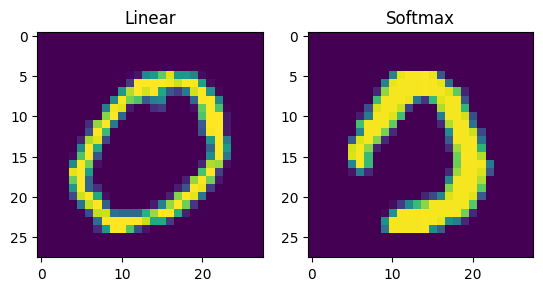

In [10]:
linear = RecurrentGenerator(256, 783, 10, "linear", 8, 8)
linear.load_state_dict(linear_weights)
linear.eval()
full = RecurrentGenerator(256, 783, 10, "full", 8, 8)
full.load_state_dict(softmax_weights)
full.eval()


images_linear = predict_with_recurrent(linear, torch.zeros(1, 783, dtype=torch.int64), 1)
images_full = predict_with_recurrent(full, torch.zeros(1, 783, dtype=torch.int64), 1)

import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Linear")
ax[0].imshow(images_linear[0].cpu().numpy().reshape(28, 28))
ax[1].set_title("Softmax")
ax[1].imshow(images_full[0].cpu().numpy().reshape(28, 28))

In [11]:
print(torch.zeros(1, 783, dtype=torch.int64).shape)
print(images_linear.shape)

torch.Size([1, 783])
torch.Size([1, 784, 1])


#Image Completion

We will sample any 5 numbers from 0-10 and access the image corresponding to it and give it as a input to predict_with_recurrent to check if it can regenerate the same image given half of the information about the image. We choose 0,1,2,3,4 to test on experiment around the occulated data.

The following code takes the dataset for the num 0,1,2,3,4 and visualises the dataset for the same

Create occulated images of the dataset. We will now only store information about half of this image. or say, stop the data visualisation at just half.

In [12]:
import pandas as pd

# Replace 'your_file.csv' with the actual filename
data = pd.read_csv('data/mnist_test.csv')
data=np.array(data)

In [13]:

list=[]

for x in data:
    if x[0]==0:
      list.append(x)
      break
for x in data:
    if x[0]==1:
      list.append(x)
      break
for x in data:
    if x[0]==2:
      list.append(x)
      break
for x in data:
    if x[0]==3:
      list.append(x)
      break
for x in data:
    if x[0]==4:
      list.append(x)
      break



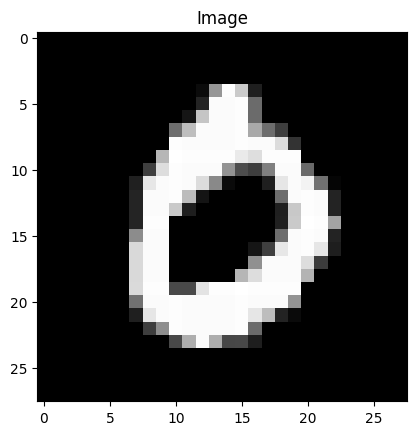

torch.Size([28, 28])


/tmp/ipykernel_1529365/3498340128.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x=torch.tensor([x])


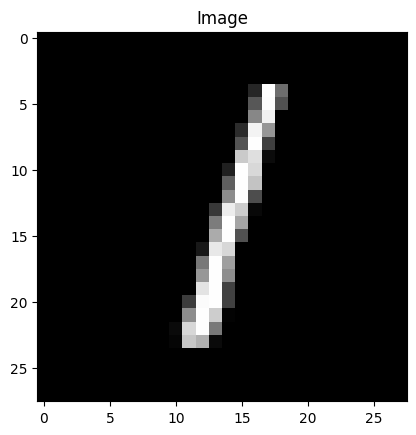

torch.Size([28, 28])


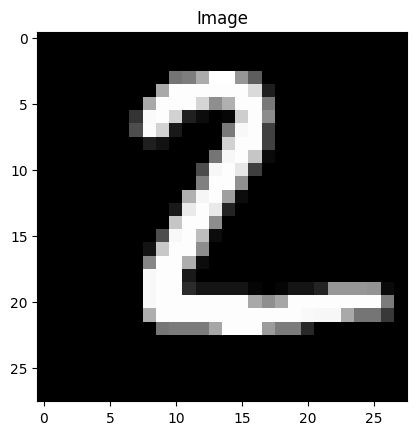

torch.Size([28, 28])


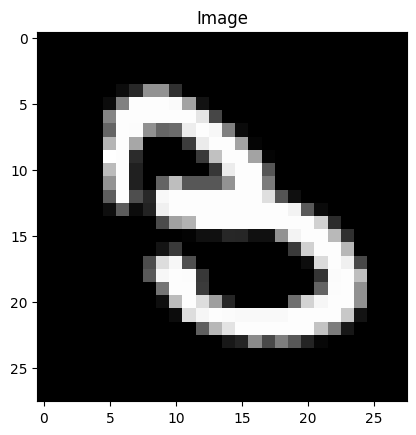

torch.Size([28, 28])


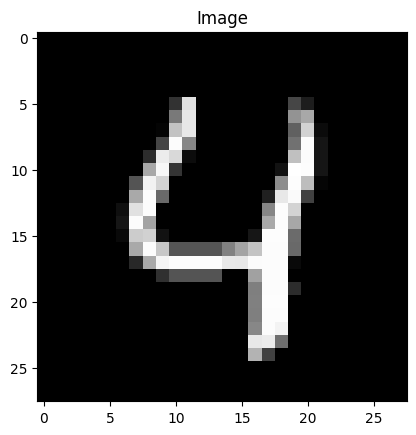

torch.Size([28, 28])


In [14]:
for x in list:
  x=x[1:]
  # x=torch.tensor([x])
  x=x.reshape(28, 28)
   # Display the image using matplotlib
  plt.imshow(x, cmap='gray')  # Use 'gray' for grayscale images
  plt.title("Image")
  plt.show()
  x=torch.tensor([x])
  x=x.squeeze()
  print(x.shape)

In [15]:
def occlude_half_image2(image):
  """Ocludes half of the image (top half by default).

  Args:
      image: A PyTorch tensor representing the image (channels, height, width).

  Returns:
      A PyTorch tensor representing the occluded image.
  """
  image_size = image.shape[1]  # Get image height or width (assuming square images)
  mask = torch.zeros_like(image)  # Create a mask with the same size as the image
  mask[:, :image_size // 2] = 1  # Set half of the mask to 1 (top half)
  return image * mask  # Apply the mask

def occlude_half_image(image):
    """
    Ocludes half of the image (top half by default).

    Args:
        image: A PyTorch tensor representing the image (channels, height, width).

    Returns:
        A PyTorch tensor representing the occluded image.
    """

    # Get image height
    image_size = image.shape[1]

    # Create a mask with the same size as the image
    mask = torch.zeros_like(image)

    # Set half of the mask to 1 (top half by default)
    mask[:, :image_size // 2] = 1

    # Apply the mask to occlude half of the image
    return image * mask


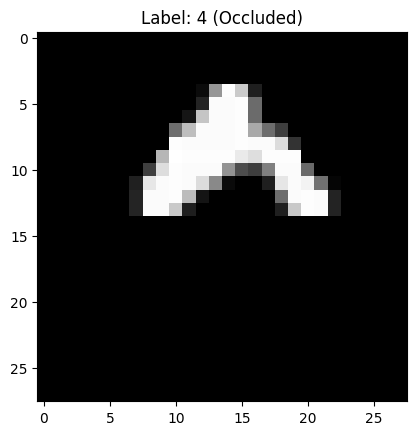

torch.Size([28, 28])


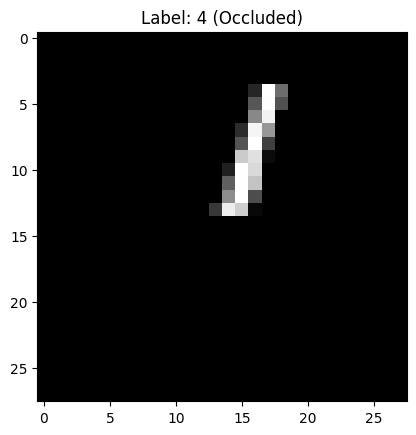

torch.Size([28, 28])


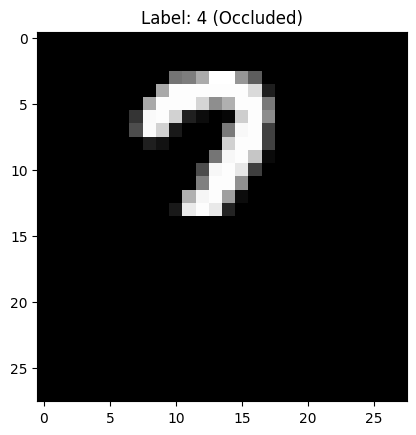

torch.Size([28, 28])


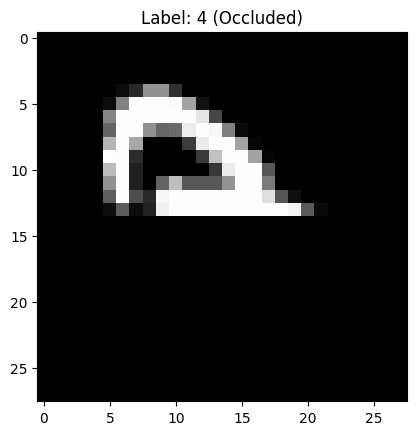

torch.Size([28, 28])


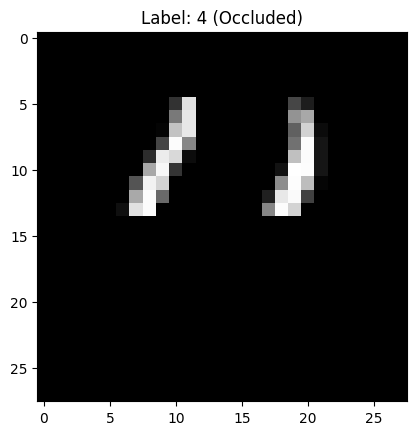

torch.Size([28, 28])


In [16]:

images_to_visualize = []

for label in range(5):  # Collect images with labels 0 to 4 (inclusive)
  for x in data:
    if x[0] == label:
      images_to_visualize.append(x[1:])  # Extract image data and skip label
      break  # Stop after finding one image for each label

for image in images_to_visualize:
  image_tensor = torch.from_numpy(image.reshape(28, 28))  # Create tensor
  occluded_image = occlude_half_image(image_tensor.unsqueeze(0))  # Add batch dim, occlude
  occluded_image = occluded_image.squeeze()  # Remove batch dim (if needed)

  plt.imshow(occluded_image.numpy(), cmap='gray')
  plt.title(f"Label: {label} (Occluded)")
  plt.show()

  print(occluded_image.shape)

In [17]:

occluded_dataset=[]
for image in images_to_visualize:
  image_tensor = torch.from_numpy(image.reshape(28, 28))  # Create tensor
  occluded_image = occlude_half_image(image_tensor.unsqueeze(0))
  occluded_dataset.append(occluded_image)  # Add batch dim, occlude

print(occluded_dataset[0].shape)


torch.Size([1, 28, 28])


Now test the model

In [18]:
def prepare_image_for_model(image):
  """
  Flattens the image tensor for model input.

  Args:
      image: A PyTorch tensor representing the image (channels, height, width).

  Returns:
      A PyTorch tensor representing the flattened image (channels * height * width).
  """

  # Assuming the image has a single channel (modify if channels > 1)
  return image.view(image.shape[0], -1)  # Flatten all dimensions except the first (batch size)



In [19]:
flatten_image=[]
for images in occluded_dataset:
  flat=prepare_image_for_model(images)
  flat=flat[:,:-1]
  flatten_image.append(flat)

print(flatten_image[0].shape)

torch.Size([1, 783])


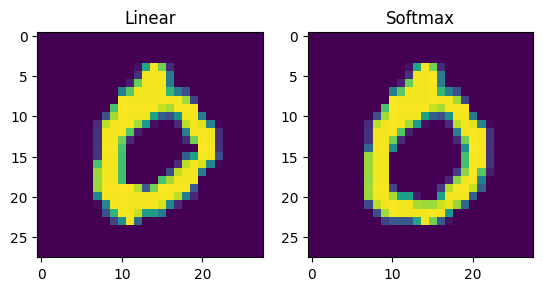

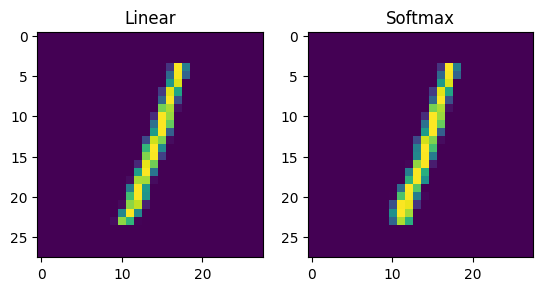

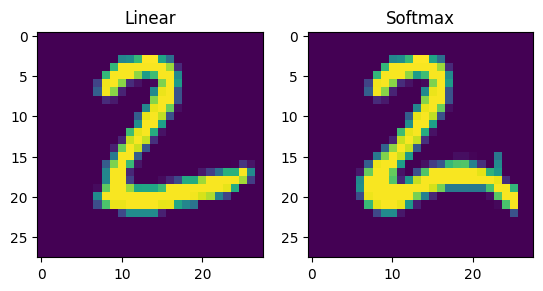

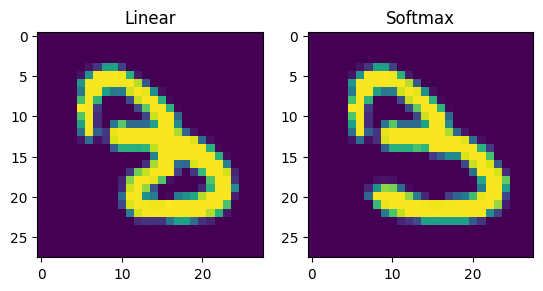

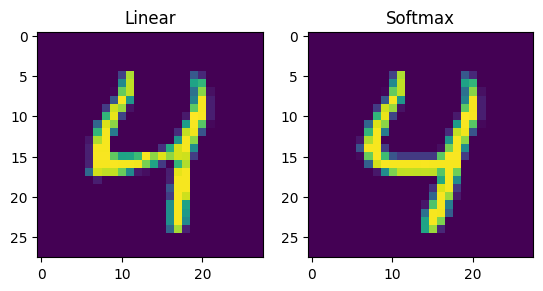

In [20]:


linear = RecurrentGenerator(256, 783, 10, "linear", 8, 8)
linear.load_state_dict(linear_weights)
linear.eval()
full = RecurrentGenerator(256, 783, 10, "full", 8, 8)
full.load_state_dict(softmax_weights)
full.eval()

for i in range(5):
  image=flatten_image[i]
  images_linear = predict_with_recurrent(linear, image, 392)
  images_full = predict_with_recurrent(full, image, 392)

  import numpy as np
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots(1, 2)
  ax[0].set_title("Linear")
  ax[0].imshow(images_linear[0].cpu().numpy().reshape(28, 28))
  ax[1].set_title("Softmax")
  ax[1].imshow(images_full[0].cpu().numpy().reshape(28, 28))

#Testing accuracy in MNIST for linear and softmax based attention

I mean of course both of the models were able to complete the task but to test which one is better what we can do is complete the image for all of the possible images in the training data and now train a new neural network on this data and then test the MNIST test dataset.

Load the whole training MNIST dataset

In [24]:
import pandas as pd

# Replace 'your_file.csv' with the actual filename
data = pd.read_csv('data/mnist_train_small.csv')
data=np.array(data)

train_x=[ ]
train_y=[ ]

for x in data[:600]:
  x=x[1:]
  # x=torch.tensor([x])
  x=x.reshape(28, 28)
  # x=torch.tensor([x])
  # x=x.squeeze()
  train_x.append(x)

print(len(train_x))



600


In [25]:
for x in data[:600]:
  x=x[0]
  train_y.append(x)

print(len(train_y))

600


Occlude the whole set of training data and prepare for completion

In [26]:
occluded_dataset=[]
for image in train_x:
  image_tensor = torch.from_numpy(image.reshape(28, 28))  # Create tensor
  occluded_image = occlude_half_image(image_tensor.unsqueeze(0))
  occluded_dataset.append(occluded_image)  # Add batch dim, occlude

print(len(occluded_dataset))


600


In [27]:
flatten_image=[]
for images in occluded_dataset:
  flat=prepare_image_for_model(images)
  flat=flat[:,:-1]
  flatten_image.append(flat)
print(len(flatten_image))
print(flatten_image[0].shape)

600
torch.Size([1, 783])


Complete the images.

In [28]:

linear = RecurrentGenerator(256, 783, 10, "linear", 8, 8)
linear.load_state_dict(linear_weights)
linear.eval()
full = RecurrentGenerator(256, 783, 10, "full", 8, 8)
full.load_state_dict(softmax_weights)
full.eval()
image_linear_train=[]
image_full_train=[]
for i in range(len(flatten_image)):
  print(i)
  image=flatten_image[i]
  images_linear = predict_with_recurrent(linear, image, 392)
  image_linear_train.append(images_linear)
  images_full = predict_with_recurrent(full, image, 392)
  image_full_train.append(images_full)

print(len(image_linear_train))
print(len(image_full_train))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [47]:
# save image_linear_train and image_full_train to csv files in data/
import csv

with open('data/image_linear_train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for i in image_linear_train:
        writer.writerow(i)
        
with open('data/image_full_train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for i in image_full_train:
        writer.writerow(i)

Train any neural network


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming train_x is a list of tensors of size (784,) and train_y is a list of integer labels

# Hyperparameters
num_epochs = 10
batch_size = 20
learning_rate = 0.001

# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)  # 10 output neurons for 10 digits

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)  # No activation for output layer (softmax will be applied later)
        return x



In [31]:
def train_model(model, x, y,optimizer, loss_function, num_epochs):
  model.train()
  for epoch in range(num_epochs):
    pred = model(x)
    loss = loss_function(pred, labels)
    predictions = torch.argmax(pred, dim=1)
    accuracy = (predictions == labels).sum() / len(labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy}")


In [68]:
images_linear = []
for image in image_linear_train:
  images_linear.append(image.squeeze())
images_linear = torch.stack(images_linear)

labels = torch.tensor(train_y)

In [33]:
print(len(train_y))
print(labels.shape)

600
torch.Size([600])


In [34]:
nn_linear = NeuralNetwork()
nn_linear.to(device)
images_linear = images_linear.to(device, dtype=torch.float32)
labels = labels.to(device, dtype=torch.long)
loss_func_linear = nn.CrossEntropyLoss()
loss_func_linear.to(device)
optimizer_linear = torch.optim.Adam(nn_linear.parameters(), lr=learning_rate)


In [35]:
train_model(nn_linear, images_linear, labels, optimizer_linear, loss_func_linear, num_epochs)

Epoch: 1, Loss: 9.8757, Accuracy: 0.13500000536441803
Epoch: 2, Loss: 6.4338, Accuracy: 0.23666667938232422
Epoch: 3, Loss: 4.4993, Accuracy: 0.2849999964237213
Epoch: 4, Loss: 3.0018, Accuracy: 0.3933333456516266
Epoch: 5, Loss: 2.2806, Accuracy: 0.445000022649765
Epoch: 6, Loss: 1.8753, Accuracy: 0.46833333373069763
Epoch: 7, Loss: 1.5940, Accuracy: 0.5250000357627869
Epoch: 8, Loss: 1.2584, Accuracy: 0.6116666793823242
Epoch: 9, Loss: 0.9551, Accuracy: 0.6700000166893005
Epoch: 10, Loss: 0.7942, Accuracy: 0.7283333539962769


In [36]:
images_full = []
for image in image_full_train:
  images_full.append(image.squeeze())
images_full = torch.stack(images_full)

In [37]:
nn_full = NeuralNetwork()
nn_full.to(device)
images_full = images_full.to(device, dtype=torch.float32)
labels = labels.to(device, dtype=torch.long)
loss_func_full = nn.CrossEntropyLoss()
loss_func_full.to(device)
optimizer_full = torch.optim.Adam(nn_full.parameters(), lr=learning_rate)

In [38]:
train_model(nn_full, images_full, labels, optimizer_full, loss_func_full, num_epochs)

Epoch: 1, Loss: 10.7619, Accuracy: 0.09000000357627869
Epoch: 2, Loss: 5.9147, Accuracy: 0.16833333671092987
Epoch: 3, Loss: 3.4925, Accuracy: 0.29500001668930054
Epoch: 4, Loss: 2.3397, Accuracy: 0.43666666746139526
Epoch: 5, Loss: 1.7442, Accuracy: 0.5616666674613953
Epoch: 6, Loss: 1.3418, Accuracy: 0.6516667008399963
Epoch: 7, Loss: 1.0108, Accuracy: 0.7150000333786011
Epoch: 8, Loss: 0.8492, Accuracy: 0.7716667056083679
Epoch: 9, Loss: 0.7916, Accuracy: 0.7933333516120911
Epoch: 10, Loss: 0.7138, Accuracy: 0.8066666722297668


Prepare the testdata

In [43]:
import pandas as pd

# Replace 'your_file.csv' with the actual filename
data = pd.read_csv('data/mnist_test.csv')
data=np.array(data)

# test_x=[ ]
# test_y=[ ]

# for x in data:
#   test_x.append(x[1:])
#   test_y.append(x[0])

#   test_y.append(y)

test_x = torch.tensor(data[:, 1:], dtype=torch.float32).to(device)
test_y = torch.tensor(data[:, 0]).to(device)

print(len(test_x))
print(len(test_y))


9999
9999


Test the data

In [44]:
def evaluate_model(model, test_images, test_labels, loss_func):
  """
  Evaluates the model on the given test data and labels.

  Args:
      model (nn.Module): The PyTorch model to evaluate.
      test_images (torch.Tensor): The test data tensor.
      test_labels (torch.Tensor): The test labels tensor.
      loss_func (nn.Module): The loss function to use.

  Returns:
      float: The accuracy of the model on the test data.
      float: The loss of the model on the test data.
  """
  model.eval()
  with torch.no_grad():  # Deactivate gradient calculation for evaluation
    predictions = model(test_images)
    loss = loss_func(predictions, test_labels)
    predicted_labels = torch.argmax(predictions, dim=1)
    num_correct = (predicted_labels == test_labels).sum().item()
    accuracy = num_correct / len(test_labels)
    print(f"Accuracy: {accuracy:.4f}, Loss: {loss.item():.4f}")
  return accuracy, loss


In [45]:
evaluate_model(nn_linear, test_x, test_y, nn.CrossEntropyLoss())

Accuracy: 0.6610, Loss: 1.1016


(0.660966096609661, tensor(1.1016, device='cuda:0'))

In [46]:
evaluate_model(nn_full, test_x, test_y, nn.CrossEntropyLoss())

Accuracy: 0.7218, Loss: 1.0231


(0.7217721772177218, tensor(1.0231, device='cuda:0'))

In [62]:
optimizer_test = torch.optim.Adam(nn_linear.parameters(), lr=learning_rate)
loss_func_test = nn.CrossEntropyLoss()
num_epochs = 50

In [63]:
image_test = test_x
print(test_x.shape)
labels = torch.tensor(test_y)

torch.Size([9999, 784])


/tmp/ipykernel_1529365/3998451009.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(test_y)


In [64]:
nn_test = NeuralNetwork()
nn_test.to(device)
image_test = image_test.to(device, dtype=torch.float32)
labels = labels.to(device, dtype=torch.long)
loss_func_test = nn.CrossEntropyLoss()
loss_func_test.to(device)
optimizer_test = torch.optim.Adam(nn_test.parameters(), lr=learning_rate)

In [65]:
train_model(nn_test, test_x, test_y, optimizer_test, loss_func_test, num_epochs)

Epoch: 1, Loss: 10.4984, Accuracy: 0.11591159552335739
Epoch: 2, Loss: 6.0916, Accuracy: 0.22142215073108673
Epoch: 3, Loss: 3.0061, Accuracy: 0.37033703923225403
Epoch: 4, Loss: 2.4279, Accuracy: 0.4749475121498108
Epoch: 5, Loss: 1.8539, Accuracy: 0.5557555556297302
Epoch: 6, Loss: 1.3881, Accuracy: 0.6312631368637085
Epoch: 7, Loss: 1.2243, Accuracy: 0.6713671684265137
Epoch: 8, Loss: 1.0122, Accuracy: 0.7273727655410767
Epoch: 9, Loss: 0.8928, Accuracy: 0.7617762088775635
Epoch: 10, Loss: 0.8502, Accuracy: 0.7799779772758484
Epoch: 11, Loss: 0.7808, Accuracy: 0.7994799613952637
Epoch: 12, Loss: 0.7024, Accuracy: 0.8172817230224609
Epoch: 13, Loss: 0.6375, Accuracy: 0.8323832750320435
Epoch: 14, Loss: 0.6031, Accuracy: 0.8408840894699097
Epoch: 15, Loss: 0.5886, Accuracy: 0.8451845049858093
Epoch: 16, Loss: 0.5685, Accuracy: 0.8490849137306213
Epoch: 17, Loss: 0.5282, Accuracy: 0.8584858775138855
Epoch: 18, Loss: 0.4823, Accuracy: 0.8685868382453918
Epoch: 19, Loss: 0.4513, Accuracy

In [69]:
print(images_linear.shape)
print(images_full.shape)

torch.Size([600, 784])
torch.Size([600, 784])


In [90]:
images_linear = []
for image in image_linear_train:
  images_linear.append(image.squeeze())
images_linear = torch.stack(images_linear).to(device, dtype=torch.float32)

labels_linear = torch.tensor(train_y).to(device, dtype=torch.long)

In [91]:
images_full = []
for image in image_full_train:
  images_full.append(image.squeeze())
images_full = torch.stack(images_full).to(device, dtype=torch.float32)

labels_full = torch.tensor(train_y).to(device, dtype=torch.long)

In [92]:
evaluate_model(nn_test, images_linear, labels_linear, nn.CrossEntropyLoss())

Accuracy: 0.8700, Loss: 0.6463


(0.87, tensor(0.6463, device='cuda:0'))

In [93]:
evaluate_model(nn_test, images_full, labels_full, nn.CrossEntropyLoss())

Accuracy: 0.8633, Loss: 0.5982


(0.8633333333333333, tensor(0.5982, device='cuda:0'))